# Wheat Head Diseases Detection
Performs fine tuning on Keras VGG16 in order to detect Wheat Head diseases such as:  Fusarium Head Blight, Leaf Rust and Tan Spot

In [48]:
# Import Keras with tensorflow backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

### Settings

In [49]:
# Set dataset folder path
BASE_DATASET_FOLDER = ("C:/Users/Miss_A/Desktop/WH-diseases-detection/dataset")
TRAIN_FOLDER = "train"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# ResNet50 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
MODEL_PATH = os.path.join("WH_diseases_detection.h5")

### Data agumentation

In [50]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)


Found 738 images belonging to 4 classes.


In [51]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 76 images belonging to 4 classes.


In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 283 images belonging to 4 classes.


In [53]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Fusarium Head Blight', 1: 'Healthy Wheat', 2: 'Leaf Rust', 3: 'Tan Spot'}


### Load VGG16
Load the pre-trained VGG16 model without the top layer

In [54]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

### Freeze the layers except the last 4 layers

In [55]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

### Create model

In [56]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [57]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 1028)              25791492  
                                                                 
 dropout_6 (Dropout)         (None, 1028)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               263424    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                

### Compile model
Compile model specifying the optimizer learning rate

In [58]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
              metrics=['acc'])

### Train model
train model using validation dataset for validate each steps

In [59]:
%%time
 
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/50
11/11 [==============================] - 141s 12s/step - loss: 1.5644 - acc: 0.3509 - val_loss: 0.8869 - val_acc: 0.6094
Epoch 2/50
11/11 [==============================] - 134s 12s/step - loss: 1.0970 - acc: 0.5475 - val_loss: 0.7127 - val_acc: 0.7188
Epoch 3/50
11/11 [==============================] - 118s 10s/step - loss: 0.7750 - acc: 0.6914 - val_loss: 0.5228 - val_acc: 0.7969
Epoch 4/50
11/11 [==============================] - 119s 11s/step - loss: 0.6392 - acc: 0.7493 - val_loss: 0.5395 - val_acc: 0.7812
Epoch 5/50
11/11 [==============================] - 119s 11s/step - loss: 0.6132 - acc: 0.7389 - val_loss: 0.4334 - val_acc: 0.7969
Epoch 6/50
11/11 [==============================] - 132s 12s/step - loss: 0.5124 - acc: 0.8012 - val_loss: 0.5172 - val_acc: 0.7500
Epoch 7/50
11/11 [==============================] - 124s 11s/step - loss: 0.5438 - acc: 0.7938 - val_loss: 0.4678 - val_acc: 0.7812
Epoch 8/50
11/11 [==============================] - 124s 11s/step - loss: 0.

In [60]:
model.save(MODEL_PATH)

### Check Performance
Plot training and validation accuracy and loss

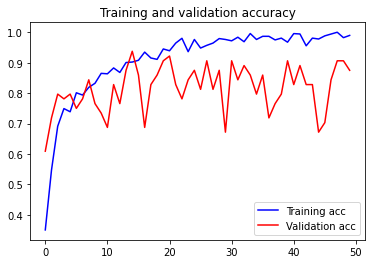

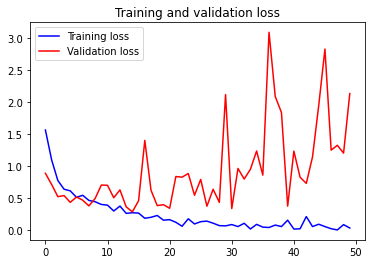

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Test model
Evauate model using test dataset

In [62]:
%%time
loss, accuracy = model.evaluate_generator(test_generator)

CPU times: total: 2min 30s
Wall time: 42.2 s


In [63]:
print("Accuracy: %f/nLoss: %f" % (accuracy,loss))

Accuracy: 0.826855/nLoss: 1.606796


### Confusion Matrix
Build and plot confusion matrix

In [64]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)

36/36 [==============================] - 39s 1s/step
CPU times: total: 2min 53s
Wall time: 39.6 s


In [65]:
y_pred = np.argmax(Y_pred, axis=1)

In [66]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [67]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

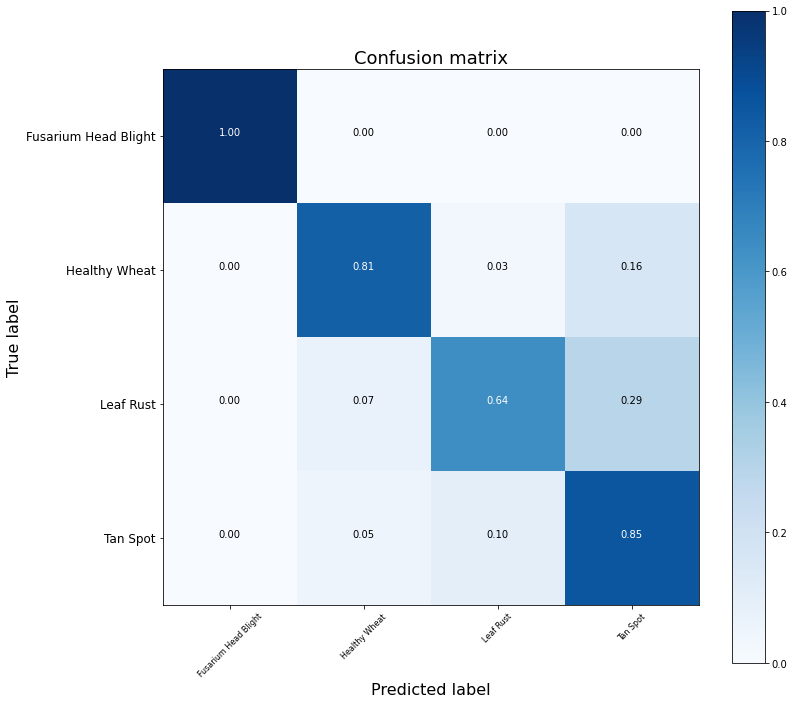

In [68]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

### Classification Report
Print classification report

In [69]:
print(classification_report(test_generator.classes, y_pred, target_names=list(classes.values())))

                      precision    recall  f1-score   support

Fusarium Head Blight       1.00      1.00      1.00        75
       Healthy Wheat       0.88      0.81      0.85        75
           Leaf Rust       0.85      0.64      0.73        72
            Tan Spot       0.61      0.85      0.71        61

            accuracy                           0.83       283
           macro avg       0.84      0.83      0.82       283
        weighted avg       0.85      0.83      0.83       283



### Random test
Random sample images from test dataset and predict 

In [70]:
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

File: Tan Spot\2121.jpg
1/1 [==============================] - 0s 332ms/step
{'Tan Spot': 0.99999654}


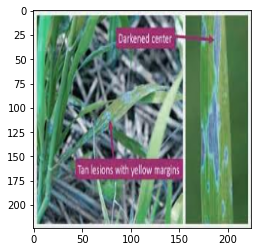

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02631.jpg
1/1 [==============================] - 0s 141ms/step
{'Fusarium Head Blight': 0.9621604}


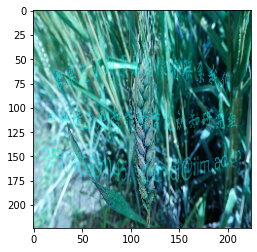

File: Leaf Rust\03431.jpg
1/1 [==============================] - 0s 137ms/step
{'Tan Spot': 0.9999714}


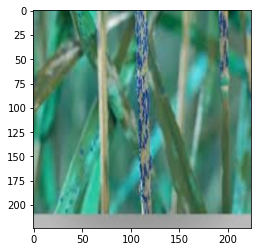

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02951.jpg
1/1 [==============================] - 0s 136ms/step
{'Fusarium Head Blight': 0.9622252}


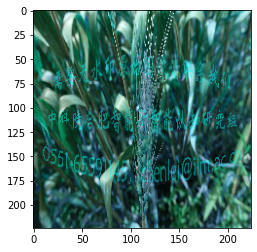

<Figure size 432x288 with 0 Axes>

File: Healthy Wheat\02791.jpg
1/1 [==============================] - 0s 135ms/step
{'Tan Spot': 0.9999981}


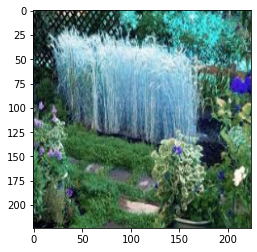

<Figure size 432x288 with 0 Axes>

File: Healthy Wheat\02221.jpg
1/1 [==============================] - 0s 138ms/step
{'Tan Spot': 0.97046185}


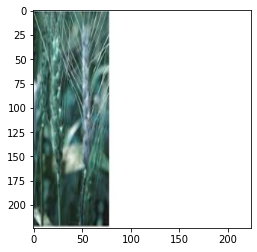

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02381.jpg
1/1 [==============================] - 0s 136ms/step
{'Fusarium Head Blight': 1.0}


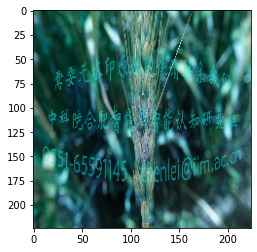

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\03001.jpg
1/1 [==============================] - 0s 139ms/step
{'Healthy Wheat': 0.99945945}


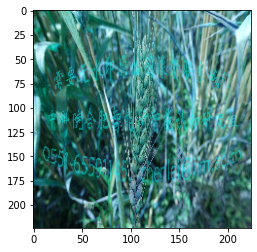

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02301.jpg
1/1 [==============================] - 0s 138ms/step
{'Fusarium Head Blight': 1.0}


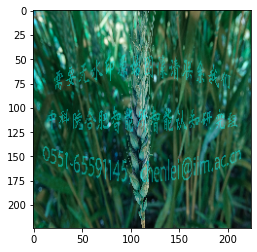

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03821.jpg
1/1 [==============================] - 0s 137ms/step
{'Leaf Rust': 0.99999964}


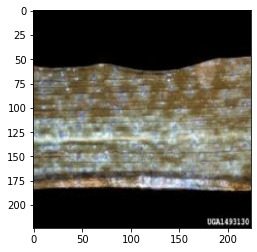

<Figure size 432x288 with 0 Axes>

File: Healthy Wheat\02481.jpg
1/1 [==============================] - 0s 155ms/step
{'Healthy Wheat': 1.0}


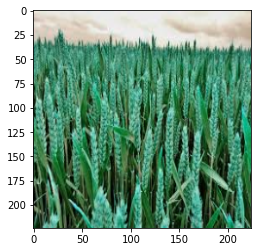

<Figure size 432x288 with 0 Axes>

File: Tan Spot\2321.png
1/1 [==============================] - 0s 141ms/step
{'Tan Spot': 0.99999976}


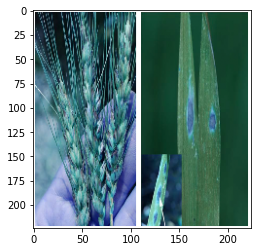

<Figure size 432x288 with 0 Axes>

File: Tan Spot\2381.jpg
1/1 [==============================] - 0s 141ms/step
{'Tan Spot': 1.0}


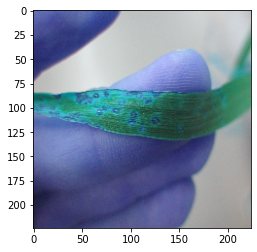

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03081.jpg
1/1 [==============================] - 0s 135ms/step
{'Leaf Rust': 0.9719902}


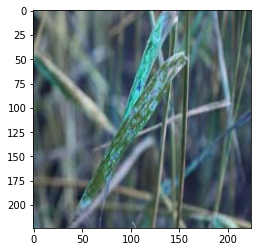

<Figure size 432x288 with 0 Axes>

File: Tan Spot\2611.jpg
1/1 [==============================] - 0s 134ms/step
{'Tan Spot': 1.0}


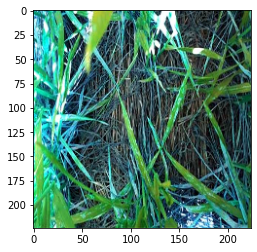

<Figure size 432x288 with 0 Axes>

File: Healthy Wheat\02251.jpg
1/1 [==============================] - 0s 136ms/step
{'Healthy Wheat': 1.0}


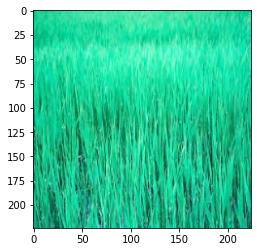

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02881.jpg
1/1 [==============================] - 0s 134ms/step
{'Fusarium Head Blight': 1.0}


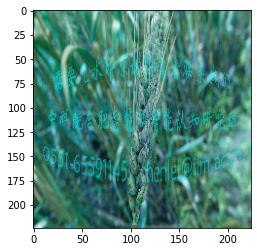

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03601.jpg
1/1 [==============================] - 0s 136ms/step
{'Leaf Rust': 0.9968246}


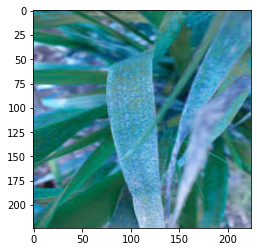

<Figure size 432x288 with 0 Axes>

File: Healthy Wheat\02851.jpg
1/1 [==============================] - 0s 136ms/step
{'Healthy Wheat': 1.0}


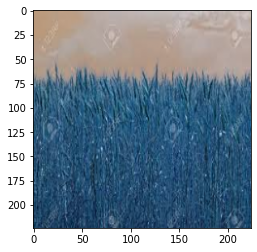

<Figure size 432x288 with 0 Axes>

File: Fusarium Head Blight\02311.jpg
1/1 [==============================] - 0s 141ms/step
{'Fusarium Head Blight': 1.0}


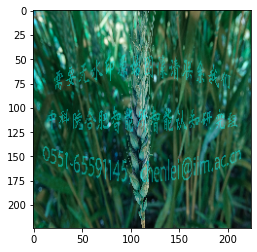

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03511.jpg
1/1 [==============================] - 0s 139ms/step
{'Leaf Rust': 0.99998736}


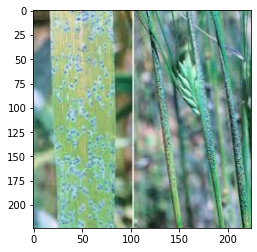

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03701.jpg
1/1 [==============================] - 0s 138ms/step
{'Tan Spot': 0.92855966}


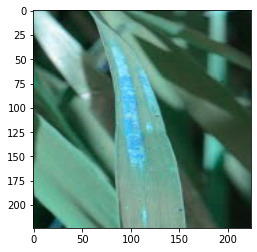

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03621.jpg
1/1 [==============================] - 0s 139ms/step
{'Healthy Wheat': 0.5563003}


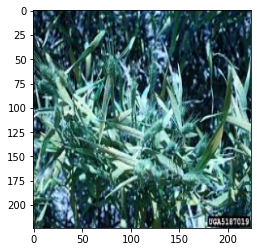

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03771.jpg
1/1 [==============================] - 0s 131ms/step
{'Tan Spot': 0.9997553}


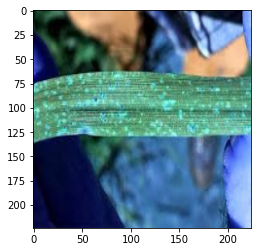

<Figure size 432x288 with 0 Axes>

File: Leaf Rust\03141.jpg
1/1 [==============================] - 0s 130ms/step
{'Healthy Wheat': 1.0}


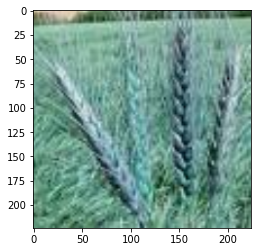

<Figure size 432x288 with 0 Axes>

In [71]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 25)):
    print("File: %s" % filename)
    
    img = load_image(filename)
    print(predict(img))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()